## Differentiable Short-Time DCT Transform in PyTorch

For one of the (many) experiments I'm conducting using GANs to produce audio, I'd like to try applying some hand-engineered features before passing the real and fake samples off to the discriminator/critic.

This is motivated by a few facts:
- there are quite a few audio transformations that happen physically/mechanically to sound before it ever reaches audio cortex.  This is true for vision as well;  we don't ask machine vision models to  work on raw light "waveforms".  Instead, we start from the assumption that the cones have already had a crack at the signal, and have decomposed it into its constituent red, green, and blue components
- there are quite a few transformations we can apply to audio that are perceptually irrelevant.  Could it be that the generator and discriminator both waste time and capacity trying to get these imperceptible details just right, at the cost of convincing samples?

Any transformation I apply needs to be differentiable to use it in the generator or discriminator network (or I need to have a clever trick for faking the gradient, at least), so this notebook will work through what it takes to get a (roughly) perceptually motivated, differentiable transform in PyTorch.


Ideally, these hand-engineered transformations I'll apply to raw audio will focus the discriminator's attention on the perceptually relevant details, and ignore the rest.

I'd like to start with raw audio, and:
0. take a rolling window over the audio
1. decompose each window into N log-spaced frequency bins
2. put coefficient magnitudes on a log scale

## Building a DCT Basis

First, let's make sure we know how to build a DCT basis, apply the transform, and invert it.

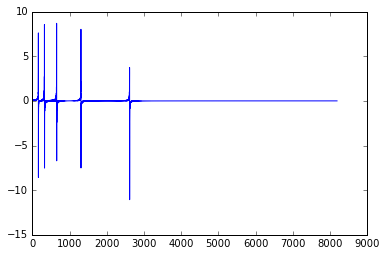

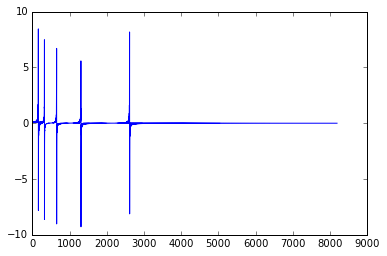

In [338]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import display, Audio, display_markdown
from scipy.fftpack import dct, idct
import zounds
import numpy as np

samplerate = zounds.SR11025()
sample_size = 8192
segment_duration = samplerate.frequency * sample_size


synth = zounds.SineSynthesizer(samplerate)
samples = synth.synthesize(
    segment_duration, 
    [110, 220, 440, 880, 1760])

# use the scipy transformation as a reference to ensure that we're
# not too far off-base
coeffs = dct(samples, norm='ortho')
recon = idct(coeffs, norm='ortho')

plt.plot(coeffs)
display_markdown('### scipy DCT', raw=True)
plt.show()

def dct_basis(size):
    r = np.arange(size)
    basis = np.outer(r, r + 0.5)
    basis = np.cos((np.pi / size) * basis)
    return basis

basis = dct_basis(len(samples))

def slow_dct(samples, basis):
    # perform the DCT transform by taking the dot product
    # of the incoming samples and the basis, and scaling
    # the coefficients
    coeffs = np.dot(samples, basis) * np.sqrt(2. / len(samples))
    
    # create a linear-spaced scale for the frequency axis
    # of the DCT coefficients
    linear_scale = zounds.LinearScale\
        .from_sample_rate(samplerate, coeffs.shape[-1])
    frequency_dimension = zounds.FrequencyDimension(linear_scale)
    
    new_dims = samples.dimensions[:-1] + (frequency_dimension,)
    
    return zounds.ArrayWithUnits(coeffs, new_dims)

def slow_inverse_dct(coeffs, basis):
    s = slow_dct(coeffs, basis.T)
    return s

coeffs2 = slow_dct(samples, basis)
plt.plot(coeffs2)
display_markdown('### Our DCT', raw=True)
plt.show()


recon2 = slow_inverse_dct(coeffs2, basis)
Audio(recon2, rate=int(samplerate))

## The Whole Transform (in NumPy)

Now that we're confident our numpy DCT implementation is mostly correct, let's move on to the rest of the transform.  Recall that we'll:

- take a sliding window over the signal
- take the DCT of each window
- map the linear-spaced DCT frequencies to log-spaced frequency bins
- map the coefficient magnitudes onto a log scale

Since our first (synthetic) signal is stationary, sliding windows over it will be very uninteresting.  Let's start working with a real-world sound.

In [339]:
from zounds.soundfile import resample
from scipy.signal import exponential

samples = zounds.AudioSamples.from_file('../audio/bach.ogg')

start = zounds.Seconds(30)
samples = resample(samples.mono[start: start + segment_duration], samplerate)

Audio(samples, rate=int(samplerate))

First, we'll take the sliding window.

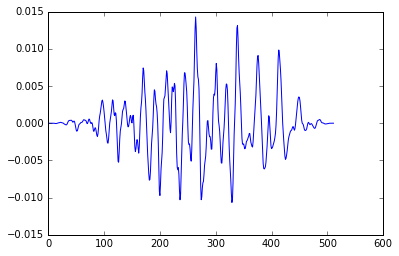

In [340]:
windowed = samples.sliding_window(zounds.HalfLapped(), padding=False)
windowed *= zounds.HanningWindowingFunc()
plt.plot(windowed[10])
display_markdown('### Hanning Windowed Audio Segment', raw=True)

Then, well take the DCT of each window, choosing our naive DCT implementation, since we'll end up doing something analogous in PyTorch

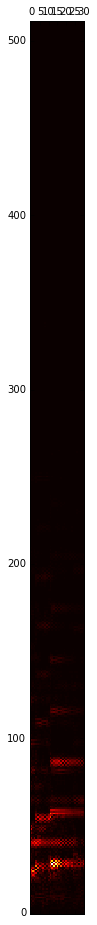

In [341]:
# create a new, smaller DCT basis for our sliding windows of audio
window_basis = dct_basis(windowed.shape[-1])

# perform the DCT transform
dct_coeffs = slow_dct(windowed, window_basis)

plt.matshow(np.abs(dct_coeffs.T), origin='lower', cmap='hot')
display_markdown('### Short-Time DCT Coefficients', raw=True)

Next, we'll map the linear-spaced frequency bins onto log-spaced bins.

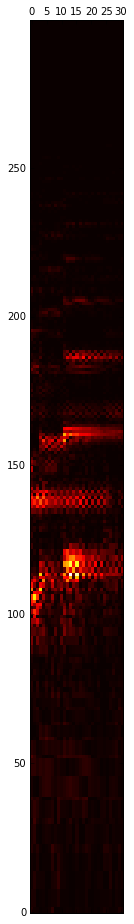

In [353]:
from scipy.signal import gaussian

scale = zounds.GeometricScale(
    start_center_hz=50,
    stop_center_hz=samplerate.nyquist,
    bandwidth_ratio=0.1,
    n_bands=300)
scale.ensure_overlap_ratio(0.5)
  
def spiky(n):
    if n == 1:
        return np.ones(n)
    
    output = np.zeros(n)
    if n % 2 == 1:
        output[(n // 2)] = 1
    else:
        output[(n // 2) - 1: (n // 2) + 1] = 0.5
    return output

geometric_coeffs = scale.apply(
    dct_coeffs, zounds.WindowingFunc(spiky))

plt.matshow(np.abs(geometric_coeffs.T), origin='lower', cmap='hot')
display_markdown('### Geometric-Scale Short-Time DCT Coefficients', raw=True)

Under the hood, `scale.apply()` is really just doing another dot product with a new basis.  Since we'll need to understand the the raw operations that are occurring in order to come up with an analogous, differentiable version in PyTorch, let's cheat a little and access the "private" method on `GeometricScale` that produces the basis.

This will give us the next set of "weights" that we'll be applying to transform our linear-spaced representation to a log-spaced one.

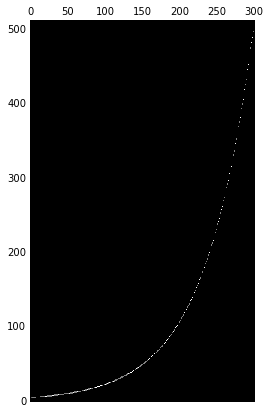

In [354]:
geometric_basis = scale._basis(
    dct_coeffs.dimensions[-1].scale, 
    zounds.WindowingFunc(spiky))

plt.matshow(geometric_basis.T, origin='lower', cmap='gray')
display_markdown('### Geometric Scale Weights', raw=True)

Now, we just have to apply this basis to our DCT coefficients, the same way we initially applied the DCT basis to our raw audio samples.

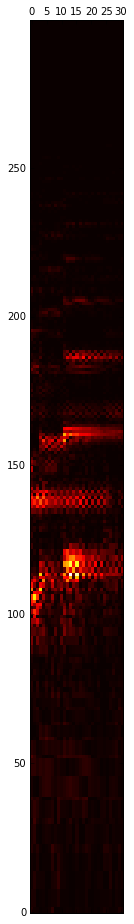

In [344]:
geometric_dct_coefficients = np.dot(np.array(dct_coeffs), geometric_basis.T)
plt.matshow(np.abs(geometric_dct_coefficients.T), origin='lower', cmap='hot')
display_markdown('### Geometric-Scale Short-Time DCT Coefficients', raw=True)

Finally, we'd like to put the coefficient magnitudes on a log scale.

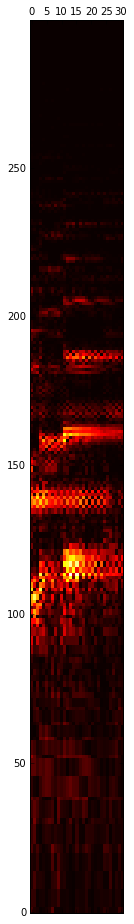

In [355]:
magnitudes = np.log(np.abs(geometric_dct_coefficients * 10) + 1)
plt.matshow(magnitudes.T, origin='lower', cmap='hot')
display_markdown('### Log Frequency _and_ Magnitude Coefficients', raw=True)

Finally, let's put together a function to perform the whole transform, invoke it, and check that we get the same answer.

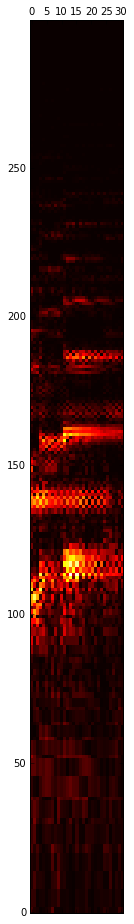

In [356]:
def geometric_dct_transform(samples, scale):
    # apply a sliding window over the raw audio samples
    windowed = samples.sliding_window(zounds.HalfLapped(), padding=False)
    windowed *= zounds.HanningWindowingFunc()
    
    # create the DCT basis, and perform the transform to
    # get linear-spaced frequency bins
    linear_basis = dct_basis(windowed.shape[-1])
    linear_coefficients = slow_dct(windowed, linear_basis)
    
    # create the basis for geometric-spaced frequency bins
    # and perform the transform
    geometric_basis = scale._basis(
        linear_coefficients.dimensions[-1].scale, 
        zounds.WindowingFunc(spiky))
    geometric_coefficients = np.dot(np.array(dct_coeffs), geometric_basis.T)
    
    # apply log-scaling to the coefficient magnitudes
    magnitudes = np.log(np.abs(geometric_coefficients * 10) + 1)
    return magnitudes
    

coeffs = geometric_dct_transform(samples, scale)

plt.matshow(coeffs.T, origin='lower', cmap='hot')
display_markdown('### Log Frequency and Magnitude Coefficients', raw=True)

## The Transform in PyTorch

Now, we're going to do it all over, but this time in PyTorch, so we've got a differentiable component that we can use as a part of a neural network.

Thankfully, we don't have to start _completely_ from scratch, since most of the heavy lifting for this transform happens with the matrix multiplications of our linear and geometric weight matrices with the samples and linear DCT coefficients, respectively.  We've already precomputed those basis/weight matrices, so we can just hand those off to PyTorch!

The only things left to cover are the sliding window and log magnitude portions of the transform.

First, let's go ahead and move our audio samples and pre-computed basis/weight matrices over to PyTorch

In [347]:
import torch
from torch.autograd import Variable

def to_var(x):
    return Variable(
        torch.from_numpy(x.astype(np.float32)), 
        requires_grad=True)

def from_var(x):
    return x.data.numpy()

# Generally, we'll be doing operations on "batches" of data
# in PyTorch, and the PyTorch convention is to shape tensors as
# (batch x channels/features x dimension)
pt_samples = to_var(samples).view((1, 1, sample_size))
pt_linear_basis = to_var(window_basis).unsqueeze(1)
pt_geometric_basis = to_var(geometric_basis).unsqueeze(2)

One thing to observe is that the initial pair of transformations

- sliding window
- matrix multiplication with DCT coefficients

looks an awful lot like a convolution.

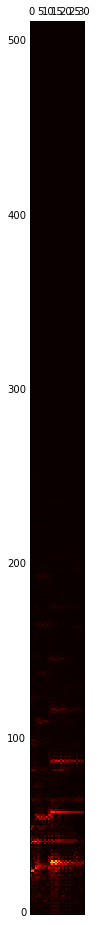

In [359]:
from torch.nn import functional as F

pt_linear_coeffs = F.conv1d(pt_samples, pt_linear_basis, stride=pt_linear_basis.shape[0] // 2)
scaling = Variable(torch.FloatTensor(1))
scaling[:] = 2. / 512
pt_linear_coeffs *= torch.sqrt(scaling)

plt.matshow(np.abs(from_var(pt_linear_coeffs)).squeeze(), origin='lower', cmap='hot')
display_markdown('### Short-Time DCT Coefficients', raw=True)

Next, we'll want to map linear frequency bins onto geometrically-spaced bins.

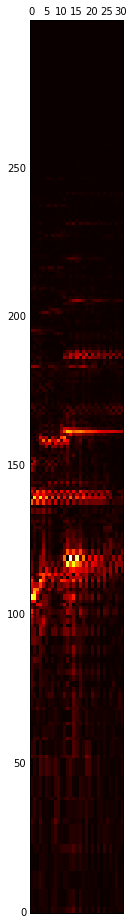

In [360]:
pt_geometric_coeffs = F.conv1d(pt_linear_coeffs, pt_geometric_basis)
plt.matshow(np.abs(from_var(pt_geometric_coeffs)).squeeze(), origin='lower', cmap='hot')
display_markdown('### Log-Frequency DCT Coefficients', raw=True)

Finally, we'll want to map magnitudes onto a log scale.

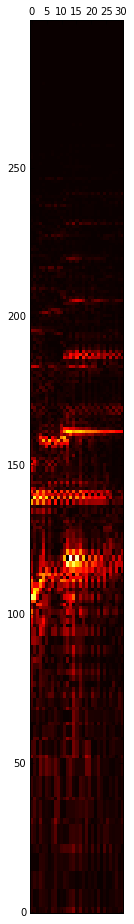

In [361]:
pt_final = torch.log(torch.abs(pt_geometric_coeffs * 10) + 1)
plt.matshow(from_var(pt_final).squeeze(), origin='lower', cmap='hot')
display_markdown('### Log Frequency _and_ Magnitude DCT Coefficients', raw=True)

Finally, let's put it all together into a single function (just like we did for the numpy version), and check our work.

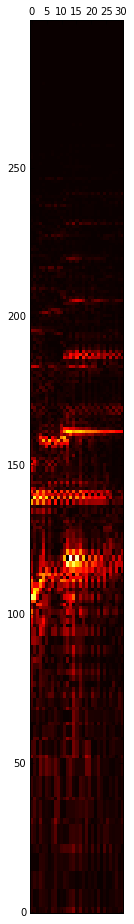

In [367]:
def pt_geometric_dct_transform(pt_samples):
    pt_linear_coeffs = F.conv1d(
        pt_samples, pt_linear_basis, stride=pt_linear_basis.shape[0] // 2)
    scaling = Variable(torch.FloatTensor(1))
    scaling[:] = 2. / 512
    pt_linear_coeffs *= torch.sqrt(scaling)
    pt_geometric_coeffs = F.conv1d(pt_linear_coeffs, pt_geometric_basis)
    pt_final = torch.log(torch.abs(pt_geometric_coeffs * 10) + 1)
    return pt_final

x = pt_geometric_dct_transform(pt_samples)
plt.matshow(from_var(x).squeeze(), origin='lower', cmap='hot')
display_markdown('### Log Frequency _and_ Magnitude DCT Coefficients', raw=True)

And _finally_, finally, the all-important question of whether this whole transform is going to be differentiable.  For this notebook, we'll just do something contrived to get a scalar value from which we can compute gradients (PyTorch only supports gradients for scalar-valued functions, and won't compute a [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) for you), but in practice, there will be many more transformations that will end with our discriminator/critic computing its estimate of the Wasserstein distance between the distribution from which the observed examples were drawn and the true/real distribution.

In [378]:
contrived_scalar = x.mean()
contrived_scalar.backward(retain_graph=True)

Well, that's that.  We've got our (roughly) perceptually-motivated, differentiable transform that we can bolt on to the front of our audio GAN critic/disriminator to force it to pay attention to what I _think_ matters more to my own ears.